In [1]:
DATAPATH = "/home/misha/Desktop/data/mnist/"

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px

In [16]:
train_df = pd.read_csv(DATAPATH + 'train.csv')
test_df = pd.read_csv(DATAPATH + 'test.csv')
sample_sub = pd.read_csv(DATAPATH + 'sample_submission.csv')

In [37]:
y_train = train_df.iloc[:, 0].values ## Get labels
X_train = train_df.iloc[:, 1:].values ## Pixels

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = test_df.values.reshape(-1, 28, 28, 1) ## No labels 

X_val, y_val = X_train[:10_000], y_train[:10_000]
X_train, y_train = X_train[10_000:], y_train[10_000:]

In [42]:
y_train.shape

(32000,)

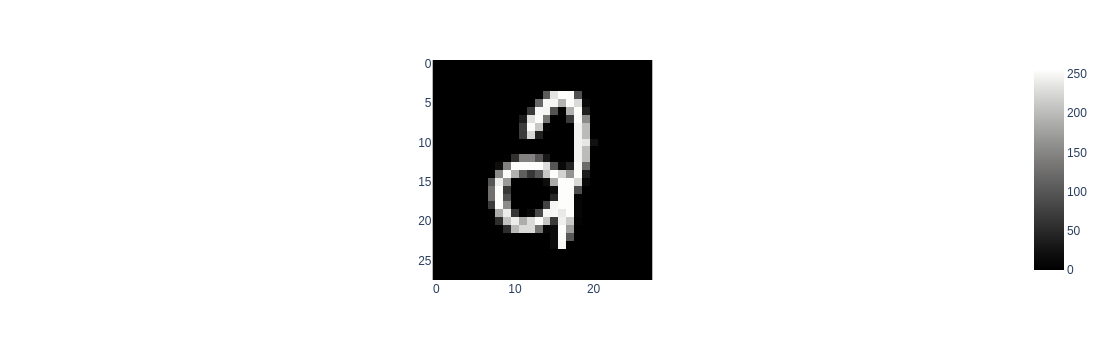

In [39]:
fig = px.imshow(X_train[0].squeeze(), color_continuous_scale='gray')
fig.show()

In [76]:
import keras_tuner as kt

def build_model(hp:kt.HyperParameters):
    ### Hyper parameters: optimizer(With momentum or not), learning_rate, number of convolutional layers
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', values=['sgd', 'nadam'])
    momentum = hp.Boolean('momentum')

    if optimizer == 'sgd' and momentum:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model
    

In [79]:
grid_search = kt.GridSearch(build_model, max_trials=10, objective='val_accuracy')
grid_search.search_space_summary()

Search space summary
Default search space size: 3
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'nadam'], 'ordered': False}
momentum (Boolean)
{'default': False, 'conditions': []}


In [80]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

grid_search.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 10 Complete [00h 00m 27s]
val_accuracy: 0.9764999747276306

Best val_accuracy So Far: 0.9764999747276306
Total elapsed time: 00h 03m 45s


In [84]:
best_params = grid_search.get_best_hyperparameters(num_trials=1)
best_params[0].params

AttributeError: 'HyperParameters' object has no attribute 'params'

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                   callbacks=[early_stop],
                   batch_size=128)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9648 - loss: 0.1392 - val_accuracy: 0.9856 - val_loss: 0.0761
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9669 - loss: 0.1241 - val_accuracy: 0.9860 - val_loss: 0.0699
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9680 - loss: 0.1144 - val_accuracy: 0.9868 - val_loss: 0.0785
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9670 - loss: 0.1237 - val_accuracy: 0.9863 - val_loss: 0.0733
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9677 - loss: 0.1126 - val_accuracy: 0.9866 - val_loss: 0.0752
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9696 - loss: 0.1107 - val_accuracy: 0.9865 - val_loss: 0.0681
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9689 - loss: 0.1071 - val_accuracy: 0.9866 - val_loss: 0.0703


# Submission Stage

In [50]:
sample_sub

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [64]:
y_pred = np.argmax(model.predict(X_test), axis=1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step


In [71]:
sub = {
    'ImageId': (test_df.index + 1),
    'Label': y_pred
}

In [72]:
submission = pd.DataFrame(sub)

In [74]:
submission.to_csv('submission.csv', index=False)